importing Jupyter notebook from Import EEG.ipynb


/home/AD/hop006/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
Import EEG.ipynb:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  "import numpy as np\n",


IndexError: tuple index out of range

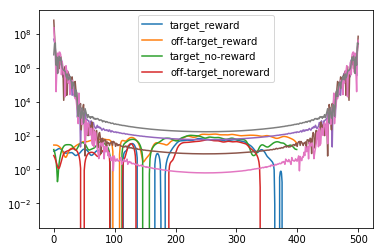

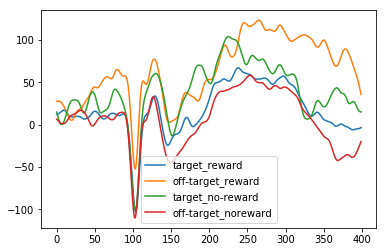

In [4]:
import impnb
import Data_processing as dp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Import_EEG

In [32]:
dp.subjects

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  1, 20, 21, 22, 23, 24,  2,
        3,  4,  5,  6,  7,  8,  9])